# Value Imputation

> I'm a substitute for another guy<br/>
> I look pretty tall but my heels are high<br/>
> The simple things you see are all complicated<br/>
> I look pretty young, but I'm just back-dated, yeah<br/>
> –Pete Townsend

Data can be missing or untrusted in a variety of ways, and for a variety of reasons.  These ways are discussed especially in chapter 4 (*Anomaly Detection*) and chapter 5 (*Data Quality*).  Sometimes your best option for dealing with bad data is simply to discard it.  However, many times it is more useful to impute values in some manner, in order to retain the rest of the features within an observation.  From the perspective of this chapter, let us assume that all data values identified as untrusted—even if initially present with *bad* values—have already been explicitly marked as missing.

When imputing data, it is important to keep a good record of the difference between values you have invented (imputed) and those that arrived with the original data set.  This record *might* take the form of an explicit annotation to each data item, depending on what your data formats enable.  The most usual way to keep records is by maintaining versions of your data as you clean them in various ways, and maintaining (and versioning) explicit scripts that perform the modifications repeatably.

Generally data comes grouped as many records or observations.  The tabular form that we ultimately require for machine learning and many statistical purposes is clear this way.  One row is an "observation," at least loosely, and each column represents a feature we wish, ideally, to have for every observation.  Even data that is intially stored in an hierarchical or otherwise non-tabular structure needs to be translated to a record-oriented representation before we do most analyses on it.  The initial form will still be partitioned in some record-like manner: maybe separate files; or separate top-level keys for nested data; or separate partitions based on some task-specific purpose.

The decision to impute values versus discard records need not be all or nothing.  It might be the case that we have decided that some records are possible or desirable to save and others are not.  Several considerations are generally present in our decision, whether done by record or for the problem generally.  The predominant emphasis in these considerations assumes a machine learning use of a data set; visualization or analytics that are not "machine learning" per se worry about imputation much less often, but definitely sometimes.  Some issues to consider include:

* Do you have *a lot* of data? If your data is limited, conserving every record possible can be especially important.  Machine learning models, *mutatis mutandis*, are that much happier the more data they have to work with.  If you have millions—or even tens of thousands—of records left after you discard those with missing data, you may be able to worry less about imputation.<sup><i>effectiveness</i></sup>  If you only have hundreds of records, every one feels precious; of course, with fewer records, flawed imputation can also have a disproportionate effect.

* Do you have knowledge or suspicion that missing data occurs in a biased way?  If the missing records are likely to concern observations that have a different characteristic or pattern than the overall data set, it can be especially important to salvage them.  Perhaps one sensor location or one time frame is closely associated with missing data. That location or time is likely to be needed to well capture some aspect of the domain modeled.

* Following on the bias issue, you may decide that it is OK to discard those records with missing data that belong to the "random flaw" subset, but that those records with systematic missing data are crucial since they address a different region of the parameter space of the problem.

* Do your records have many or few features? A record with five features and two of them missing is unlikely to retain much useful weight for good models.  A record with one feature missing out of fifty or a thousand is much more likely to be worth remediating.

* What is the role of the missing value? If the target feature is missing from a supervised learning training set—i.e. for a classification or regression problem—imputation is very unlikely to do you much good.  If it is much more likely to be useful to impute an input feature.  However, even there, the role of that input feature in the problem or domain  can vary; a particular feature can be pivotal from a "business purpose" perspective, whether or not it is actually the most predictive feature.  Imputing a feature of central task importance is generally unwise.

<div id="partnum"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>effectiveness</i><br/>
A well known and compelling essay about  how very large data sets turn out to solve many of our problems for us is <i>The Unreasonable Effectiveness of Data</i>, by Alon Halevy, Peter Norvig, and Fernando Periera.
</div>

The first two sections of this chapter look at single value imputation.  This fits straightforwardly in what we always think of as imputation.  The last section looks at oversampling and undersampling, which are whole data set modifications.  Both organizationally and conceptually, it is worth addressing those under the topic of imputation.  The goal with sampling is to produce a data set that we believe better resembles the reality we are trying to model—exactly what imputation is about.

## Typical-value Imputation

> And there's another marketing ploy<br/>
> Typical girl gets the typical boy<br/>
> –Ari Up, Paloma McLardy, Tessa Pollitt, and Viv Albertine

**Concepts**:

* Identifying values to impute
* Central tendency within a data set
* Mean, median, geometric mean, and multi-modal data
* Population-based central tendency
* Neighboring data expressing a tendency

Pretty much the simplest thing we can do is assume a missing value is similar to the general trend for that same feature.  In some cases, domain knowledge may inform us as to what a reasonable default is, in the absence of specific information about a particular record.  Absent that background, however, the data that exists can provide guidance for imputation.

### Typical Tabular Data

Let us look at the [Dermatology Data Set](https://archive.ics.uci.edu/ml/datasets/Dermatology) available from the UCI Machine Learning Repository. This data contains 34 measurements of 366 patients, with each one diagnosed as having one of six skin conditions. Most of the features are ordinal coded measures of the severity of one feature observed.

We get this data in somewhat raw form. The `dermatology.data` file is a CSV with no headers. The `dermatology.names` files contains a bit more than its name might suggest. Beyond providing the feature names, it gives additional exposition of the dataset, such as value coding, where unknown values occur, and a few other things, in prose. The `dermatology.py` file in this book's repository contains some moderate massaging of the data into a data frame.

In [1]:
from src.setup import *
from src.dermatology import *
df.iloc[:, [0, 1, 2, 3, -2, -1]].sample(6)

erythema  scaling  definite borders  itching Age               TARGET
247         2        2                 2        0  62            psoriasis
127         2        2                 2        2  44        lichen planus
230         3        2                 0        1  30  seboreic dermatitis
162         3        2                 2        2  22        lichen planus
159         3        2                 2        1  47  seboreic dermatitis
296         2        1                 1        3  19    cronic dermatitis

A quick view of sample rows does not reveal obviously missing data.  We can investigate further to identify likely missing data.  From the description provided, we know that observed severities are intended to be encoded as 0, 1, 2, or 3 (the feature "family history" as 0 or 1).  Is anything outside this coding?

In [2]:
clean, suspicious = [], {}
for col in df.columns:
    values = df[col].unique()
    if set(values) <= {0, 1, 2, 3}:
        clean.append(col)
    else:
        suspicious[col] = values

Most fields are limited to the expected coding values.

In [3]:
print("No problem detected:")
pprint(clean[:8])
print(f"... {len(clean)-8} other fields")

No problem detected:
['erythema',
 'scaling',
 'definite borders',
 'itching',
 'koebner phenomenon',
 'polygonal papules',
 'follicular papules',
 'oral mucosal involvement']
... 25 other fields


A few other fields fall outside the coding set.  However, one of them is `TARGET` which contains only reasonable names and spellings of the several conditions diagnosed.  Age, for the most part also contains reasonable human ages.  Except one value of `'?'` is also present there.  This is the manner in which this data set encodes missing data.<sup><i>missing</i></sup>

<div id="missing" 
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>missing</i><br/>
The Pandas library, in particular, by default recognizes a variety of string values as meaning "missing".  You can manually configure, per column, what values count as missing within <code>pandas.read_csv()</code> and other functions that infer data types.  As of this writing, and Pandas 1.0, these defaults are exacly these strings:  <code>''</code>, <code>'#N/A'</code>, <code>'#N/A N/A'</code>, <code>'#NA'</code>, <code>'-1.#IND'</code>, <code>'-1.#QNAN'</code>, <code>'-NaN'</code>, <code>'-nan'</code>, <code>'1.#IND'</code>, <code>'1.#QNAN'</code>, <code>'&lt;NA&gt;'</code>, <code>'N/A'</code>, <code>'NA'</code>, <code>'NULL'</code>, <code>'NaN'</code>, <code>'n/a'</code>, <code>'nan'</code>, <code>'null'</code>.

<br/>Other libraries may or may not perform similar inference/guessing, and those that do will probably use a different collection of default strings.
    
For data formats that directly encode floating-point value, often a NaN ("not a number") value, which is part of the IEEE-754 specification for floating-point numbers, is used to identify missing data.  Philosophical attitudes vary about the correctness of this encoding, but you will definitely see it often.  At other times, "special" values occur, such -1 (hopefully of a measure that must be positive) or 99999 (hopefully for a measure expected to be orders of magnitude lower).
</div>

In [4]:
# Notice age has some expected ages and also a '?'
print("Suspicious:")
pprint(suspicious)

Suspicious:
{'Age': array(['55', '8', '26', '40', '45', '41', '18', '57', '22', '30', '20',
       '21', '10', '65', '38', '23', '17', '51', '42', '44', '33', '43',
       '50', '34', '?', '15', '46', '62', '35', '48', '12', '52', '60',
       '32', '19', '29', '25', '36', '13', '27', '31', '28', '64', '39',
       '47', '16', '0', '7', '70', '37', '61', '67', '56', '53', '24',
       '58', '49', '63', '68', '9', '75'], dtype=object),
 'TARGET': array(['seboreic dermatitis', 'psoriasis', 'lichen planus',
       'cronic dermatitis', 'pityriasis rosea',
       'pityriasis rubra pilaris'], dtype=object)}


Having identified the somewhat unusual value used by this data set for missing data, we should often re-encode it using a more standard approach.  In particular, converting the string value ages to floating-point numbers with NaN used for the missing data is a very common style, and one which Pandas treats in some convenient and useful ways.  To accomplish this in Pandas, we first substitute a known "missing" value for the `'?'`, then cast the column to floating-point.  We can see that several rows have adjusted values.

In [5]:
# Assign missing ages marked with '?' as None
df.loc[df.Age == '?', 'Age'] = None  # or NaN
# Convert string/None ages to floating-point
df['Age'] = df.Age.astype(float)
# Display those rows with missing ages
df.loc[df.Age.isnull()].iloc[:, -4:]

inflammatory monoluclear inflitrate  band-like infiltrate  Age  \
33                                     0                     0  NaN   
34                                     0                     0  NaN   
35                                     0                     0  NaN   
36                                     0                     3  NaN   
262                                    3                     0  NaN   
263                                    2                     0  NaN   
264                                    3                     0  NaN   
265                                    3                     0  NaN   

                  TARGET  
33             psoriasis  
34      pityriasis rosea  
35   seboreic dermatitis  
36         lichen planus  
262    cronic dermatitis  
263    cronic dermatitis  
264    cronic dermatitis  
265    cronic dermatitis

The question arises as to what value we might impute as "typical" for this data set. 358 rows have specific ages, all in the reasonable range of human lifespans.  Eight rows have missing values.  There are a number of familiar ways of identifying the "central tendency" of a data collection.  Ones that stand out are mode, median, mean, geometric mean, and less often harmonic mean.  In Pandas specifically, only the first three of these are built-in methods.  For geometric mean or harmonic mean you will generally use `scipy.stats.gmean` or `scipy.stats.hmean` (neither is difficult to construct as a custom function).  In a different programming language or tool, these details will vary, but the concept will be the same.

Geometric mean is useful when data cover several orders of magnitude.  Often these are the same kinds of data you would plot using a log scale axis.  Measurements concerning exponental growth are often appropriately "averaged" with geometric mean.  Harmonic mean is useful when you are comparing *rates* of action.  For example, if you have a feature that measures the velocity of some objects, the typical value is best measured as harmonic mean.  Keep in mind that these several averages are often numerically close to each other, and since an imputation is a guess to begin with, the choice among them *may* be striving for a *false precision*.<sup><i>precision</i></sup>

<div id="precision" 
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>precision</i><br/>
False precision (also called overprecision, fake precision, misplaced precision and spurious precision) occurs when numerical data are presented in a manner that implies better precision than is justified; since precision is a limit to accuracy, this often leads to overconfidence in the accuracy, named <i>precision bias</i>.
</div>

For data collections that have a more-or-less linear distribution, including a normal distribution, one of the more commonplace averages is probably appropriate. We might try the modal age of the patients as a good representation.  We encounter in this data set a multi-modal distribution, which is common in small data.  Moreover, with ages between 0 and 80 years, and only 358 data points, the data is generally "lumpy."  Mode is probably not a good approach (but could be if one value clearly predominated).

In [6]:
df.Age.mode()

0    40.0
1    50.0
dtype: float64

We can use a quick plot to get a better sense of the distribution of ages, and perhaps an idea about what value might be typical.  Axis labels and ticks are omitted because we want only an overall sense of the distribution in our exploration. 

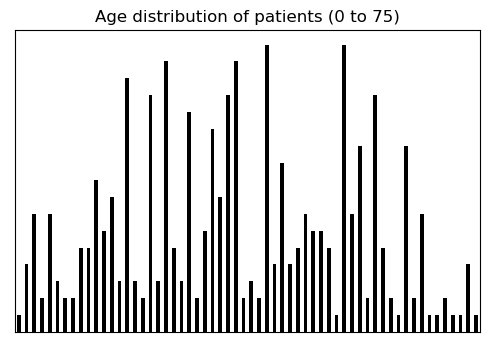

In [7]:
(df.Age
   .value_counts()
   .sort_index()
   .plot(kind="bar", yticks=[], xticks=[], 
         title="Age distribution of patients "
               f"({df.Age.min():.0f} to {df.Age.max():.0f})")
)
plt.savefig("img/(Ch06)Age distribution of patients.png")

In this case, nothing particularly jumps out as a likely candidate.  There are a few peaks only slightly less than the two modes, and no prevalent pattern to the noisy data.

Most likely mean or median are more representative.  These values come out as reasonably close to each other here, although both are notably different from both modes.

In [8]:
df.Age.mean(), df.Age.median()

(36.29608938547486, 35.0)

However, we might also attempt to use domain knowledge to make more informed choices about a value to impute.  For example, the metadata describing this data set indicates that it was developed by several Turkish researchers and published in 1998.  Patient confidentiality prohibits disclosure of more precise details, but we might consult historical demographic data, such as this table obtained from [Statista](https://www.statista.com/), based on World Trade Organization data sets.  The median age in Turkey in 1998 appears to be approximately 24 years old.

Year | Median Age | Year | Median Age
-----|------------|------|------------
1950 | 19.7       | 1990 | 21.7
1955 | 19.4       | 1995 | 23.0
1960 | 19.6       | 2000 | 24.5
1965 | 18.4       | 2005 | 26.4
1970 | 18.5       | 2010 | 28.2
1975 | 19.1       | 2015 | 29.8
1980 | 19.5       | 2020 | 31.6
1985 | 20.5       

<center>(Source: WTO, 2018; 2020 projected)</center>

Of course, if our domain knowledge ran deeper than this population information, we might also have knowledge about general age correlations with skin conditions.  As a non-expert, I tend to assume that such conditions generally increase with age, but good imputation should have a basis beyond only a vague hunch.  For purpose of this book, let us impute unknown values as the median age *within the data itself*.

In [9]:
df.loc[df.Age.isnull(), 'Age'] = df.Age.median()
df.Age.value_counts().head()

35.0    22
50.0    17
40.0    17
36.0    16
27.0    16
Name: Age, dtype: int64

Imputed 35 year olds become a bit over-represented, but not dramatically so.  And age-related tendencies should be middling for these imputed observations.

### Locality Imputation

Trends and locality are clearly related, in some sense.  For example, in a time series, the measurement taken at one particular minute is "local" to the measurement taken at the next minute by the same instrument.  That is, assuming a roughly minute-scale measurement frequency; in a domain I worked in for a number of years—molecular dynamics—time steps are roughly femtoseconds ($10^{-15}$), and a minute is vastly outside the range of any achievable simulation.  Conversely, in geology or cosmology, minutes are immeasurably small when sequencing epochs.  In any case, linear or sequential locality is addressed in the next section on trend imputation.

Locality in general, however, is not specifically about sequence.  For example, in a dimensional space—whether directly representing a physical space, or concerning a parameter or phase space—locality might simply be "closeness" in the space.  Imputing values based on the other values that are nearby is often a reasonable way of filling in data we do not actually have.  In some cases, locality-based imputation is more likely to represent the underlying data than is assuming a global default value.

For example, another data set available from the UCI Machine Learning Repository is a collection of [hand written digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) that might be recognized by an optical character recognition application.  These particular scanned images include anti-aliasing, so that the actual strokes in black ink are typically surrounded by gray pixels of varying darkness.  While adjacent boundaries between dark and light do occur, often intermediate grays exist between black and white pixels.  In photographic images, intermediate colors between regions of an image are even more common.

I have modified a subset of the UCI digit images by randomly dropping out some pixels.  In this representation, a missing gray-scale value is represented by -1.  The actual scanned pixel values are between 0 (white) and 16 (black).  Let us take a look at the data set briefly.  We can see that it is 50 samples of 8✕8 images. Each of the positions in the 8✕8 array is a a small integer. 

In [10]:
print("Array shape:", digits.shape)

Array shape: (50, 8, 8)


Each digit array has a few -1 values in it.  We can get a sense of the missing data by visualizing the pixels with shades along with values.  Several samples are shown, with each missing pixel containing an 'x' inside it.  

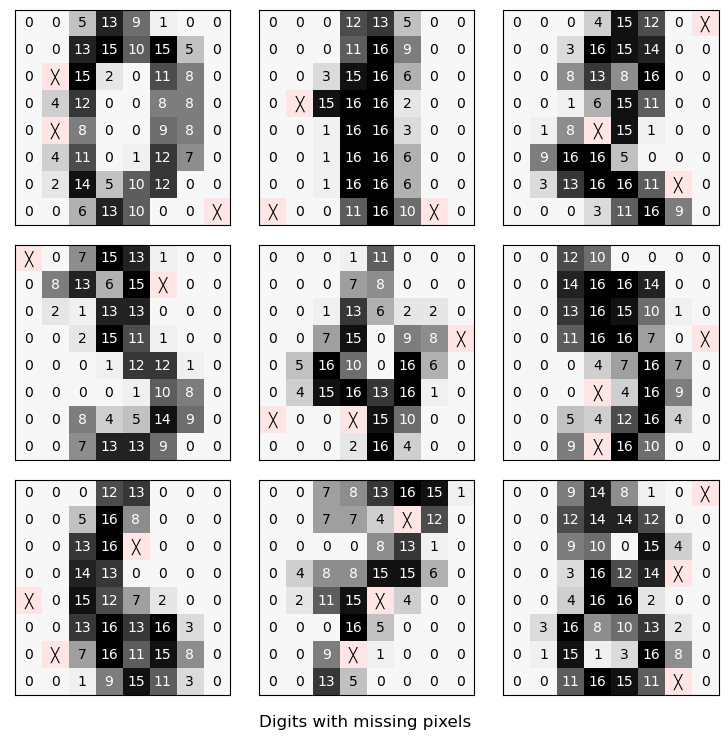

In [11]:
show_digits(digits, title="Digits with missing pixels")

If we wished to, we could apply sophisticated techniques for edge detection, convolutional filters, or the like, which might find better imputed pixels.  However, for this demonstration, we will simply assume each missing pixel is the mean value of its neighbors.  Of course, whether to weight diagonals the same as horizontal and vertical neighbors is an additional decision.  So is, potentially, a different weight for horizontal versus vertical. Or up versus down. And so on.

In [12]:
# Coded for clarity, not for best vectorized speed
# Function definition only; used in later cell
def fill_missing(digit):
    digit = digit.copy()
    missing = np.where(digit == -1)
    for y, x in zip(*missing):  # Pull off x/y position of pixel
        # Do not want negative indices in slice
        x_start = max(0, x-1)
        y_start = max(0, y-1)
        # No harm in index larger than size
        x_end = x+2
        y_end = y+2
        # What if another -1 is in region? Remove all the -1s
        region = digit[y_start:y_end, x_start:x_end].flatten()
        region = region[region >=0]
        total = np.sum(region) 
        avg = total // region.size
        digit[y, x] = avg
    return digit

The function `fill_missing()` simply creates a single new digit based on adjacent digits.  We can easily construct a new data set by looping through the samples in the original one.

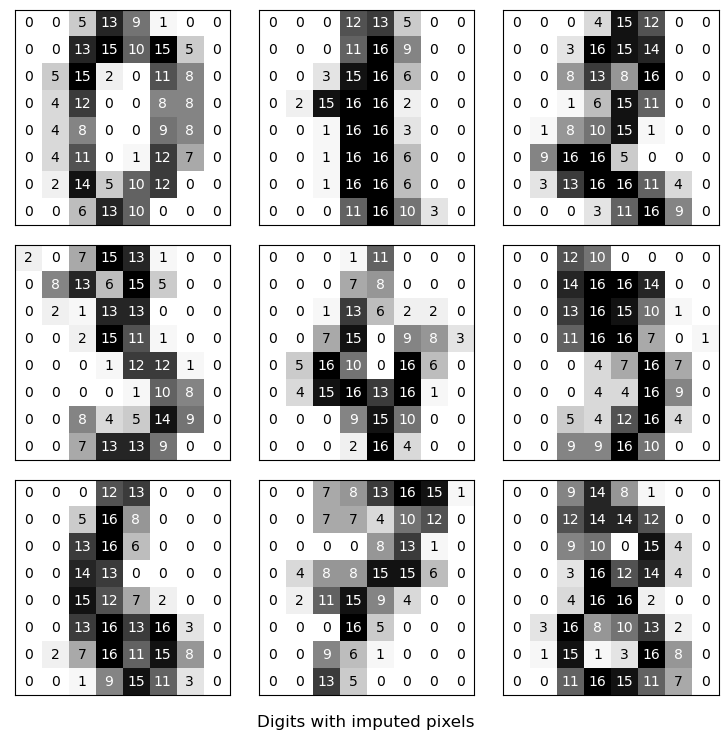

In [13]:
new = np.empty_like(digits)
for n in range(new.shape[0]):
    new[n] = fill_missing(digits[n])

show_digits(new, title="Digits with imputed pixels")

As everywhere in this book, my intention is to promote thought about the best way to improve data quality, with the flawed resources available in actual data.  The specific adjacency averaging that I perform in the sample code is *often* a reasonable approach—and apparently performs very well in the example—but you must always formulate a clear intention about what goal you have with your imputation; as well, think about how your particular approach might affect the modeling or analysis you perform later. Perhaps a different approach to imputation would work better with your selection of model.

Let us turn to trends in data, both timeseries and other kinds of linear trends.

## Trend Imputation

> The longer you stand in line, the greater the likelihood that 
> you are standing in the wrong line.<br/>–Anoynymous

**Concepts**:

* Types of trends (regressions)
  * Fill
  * Linear
  * Time-sensitive
  * Non-local
  * Correlated with another variable
* Working through a larger example: aggregation of timestamps by class
* Judging whether context is sufficient for imputation
* Static trend equivalent to central value imputation
* Trends other than time series
* Polynomial-fit trends imputation

The most obvious, and probably the most widely addressed, trend that data scientists use for imputation is time series data.  If we make observations on a relatively regular schedule—every femtosecond, every second, every minute, every year, every century, or whatever—it is reasonable, to a first approximation, to guess that a missing observeration is similar to the timestamped observations nearby to it.  One very common use of trend imputation is in financial models; for example, market trades of securities may have irregular spacing of events (either missing data, or trades being less common than the tick frequency).  However, the same concerns arise with many other domains as well.

There are several general approaches to trend imputation available.  These include forward fill, backward fill, local regression, time-sensitive regression, non-local regression, and correlational imputation. One caveat in all the imputations I discuss in this section is that they cannot deal with high-frequency signals that have a shorter periodicity than the gaps in the missing data.  For example, if something can fluctuate on a stochastic 10 hertz frequency, one-second spaced observations are going to be of little value for imputation.  Obviously, to some degree it depends on the strength of overlapping signals, but this is a concern to keep in mind.

### Types of Trends

**Forward/backward fill**: Assume that a missing value is the same as the value before/after it in the sequence.  The Pandas `Series.fillna()` method can perform this imputation, as can the `tidyr` package's `fill()` function in the R tidyverse.

**Local regression**: Assume there is a continuous function connecting the observations adjacent to the missing one.  Most of the time we simply assume a linear function; e.g. we take the mean of those adjacent observations to fill the missing value. In concept we can impute a value based on adjacent points being samples for a non-linear function, however.

**Time-sensitive regression**: Even if we look only at values adjacent to missing ones, if those adjacent values represent datetimes, we might take advantage of the actual chronological spacing of observations.  If all observations are evenly spaced in time, this is moot.  The general intuition here is that values are likely to change more in a longer time period than in a shorter one.

**Non-local regression**: Within a series, a regression can be global or windowed over a wider range than adjacent elements.  Again, a linear regression is common, and is the simplest approach, but other functional forms for a regression are possible as well.  A global or windowed regression may be less sensitive to random local fluctuations in underlying trends.  Of course, the missing datum might have been such a fluctuation itself, so this approach—and most others for trend imputation—amount to a minor degree of smoothing of variability.

**Correlation imputation**: It may be that the data in one column (feature) with missing values is significantly correlated with the data in one or more other columns.  If this is the case, it may be that models downstream should recognize the cross-correlation, for example by decomposition and dimensionality reduction.  But as an initial imputation step, assuming values based on correlations is often useful.

In somewhat technical terms, we can note that imputation usually reduces heteroscedasticity since almost every kind of imputation follows a trend, not variability from that trend. For almost all data science purposes, that is desirable, or at least acceptable, but we should avoid stating many kinds of statistical generalizations on imputed data (usually using the raw data for those purposes instead).

---

Let us look at a very simple time series example first, to illustrate several of these approaches.  We simply construct a small Pandas Series with date-level resolution, but uneven spacing of observation dates.  The first observation has a dramatically different value than later ones, mostly to emphasize that the implied global slope is different from the local differential between elements.

In [14]:
date_series

2001-01-01   -10.0
2001-01-05     1.0
2001-01-10     2.0
2001-02-01     NaN
2001-02-05     4.0
dtype: float64

Forward or backward fill are straightforward.

In [15]:
date_series.ffill()  # or .bfill()

2001-01-01   -10.0
2001-01-05     1.0
2001-01-10     2.0
2001-02-01     2.0
2001-02-05     4.0
dtype: float64

Local regression, or called plainly "averaging," is also easy.

In [16]:
date_series.interpolate('linear')

2001-01-01   -10.0
2001-01-05     1.0
2001-01-10     2.0
2001-02-01     3.0
2001-02-05     4.0
dtype: float64

In Pandas (and in other tools), we can weight a trend based on time increments.  This is still a local operation (in the sense of adjacent values), but it is a weighted average based on the greater nearness of 2001-02-01 to 2001-02-05 than to 2001-01-10.  That is, the extreme value of -10 that is non-adjacent is not utilized.

In [17]:
date_series.interpolate('time')

2001-01-01   -10.000000
2001-01-05     1.000000
2001-01-10     2.000000
2001-02-01     3.692308
2001-02-05     4.000000
dtype: float64

Given that this series is monotonically ascending, we can perform a simplified regression merely by drawing a line from the initial point to the final point.  This is not a least-squares linear regression, but it emphasizes the gap between uniform and time-based interpolation. The imputed value of 0.5 for February 1 might seem out of place, but if we visualize the global trend, it makes sense.  The OLS (ordinary least-squares) would also fall significantly below the time interpolated value, because one initial value is much lower than others later in series.

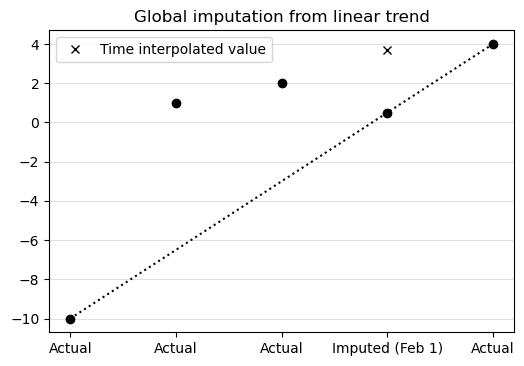

In [18]:
plot_filled_trend(date_series)

We can also look for correlations among features to imput missing values.  For example, in the dermatology data used earlier in this chapter, some observed features are clearly correlated with the `Age` feature that is occassionally missing.  In this case, all of the medical observations are ordinal, but analogous approaches would apply to continuous features.  In particular, the feature `follicular horn plug` is strongly (and monotonically) negatively correlated with patient age.  We might simply assign each missing age based on the ordinal value of that other feature. Let us calculate the mean ages for each of the `follicular horn plug` degrees. 

In [19]:
from src.dermatology import derm
feat = 'follicular horn plug'
age_groups = derm.groupby(feat).Age.mean()
age_groups

follicular horn plug
0    37.696429
1    20.400000
2    10.625000
3     9.750000
Name: Age, dtype: float64

A few lines of moderately dense Pandas code can assign to each missing `Age` based on the mean age of their grouping by the ordinal feature.  It happens that in this particular data set, all the missing ages are among patients with zero degree of "follicular horn plug," but other data would likely be different (or perhaps there is something in the collection or collation methodology that caused this correlation).

In [20]:
# The row labels for rows with missing Age
missing = derm.loc[derm.Age.isnull()].index  

# Assign Age based on mapping the feature
derm.loc[missing, 'Age'] = derm[feat].map(age_groups)

# Look at filled data for a few features
derm.loc[missing, [feat, 'scaling', 'itching', 'Age']].head(3)

follicular horn plug  scaling  itching        Age
33                     0        2        0  37.696429
34                     0        1        0  37.696429
35                     0        2        2  37.696429

The precision at which Pandas calculated mean age is not meaningful, but there is also no special benefit in explicitly reducing it.

### A Larger Coarse Time Series

The City of Philadelphia, in the U.S. state of Pennsylvania, provides a wonderful resource called [OpenDataPhilly](https://www.opendataphilly.org) which is "a catalog of open data in the Philadelphia region. In addition to being the official open data repository for the City, it includes data sets from many organizations in the region." The data set we work with in this section is valuable and good quality, but it also contains enough nuance that a number of cleanup steps will be required to shape it for our purpose.

The particular real-world data set we will discuss in this section concerns the tax-assessed market value of each property.  I obtained this data by passing an SQL query over an HTTPS interface, and getting back a JSON result.  The particular query was:

```sql
SELECT parcel_number, year, market_value FROM assessments
```

A "parcel" is simply a tax/regulatory word for property under a common deed. I should be clear to note that OpenDataPhilly actually has complete information in this returned result (at the time of this writing), but I have artificially engineered a version with randomly missing values.  The full data is in the file `philly_house.json` and the version with missing values is `philly_missing.json`, both in the repository for this book.  Approximately 5% of the market values have been replaced by NaN for the missing data.

#### Understanding the Data

I believe the service limited results to fewer than the complete data set; there are relatively few parcels included compared to the Philadelphia population.  That question is not important for this section, but would likely be relevant to examine if we had other purposes in mind.  Let us look at the data set and do some basic forensics before imputation.  It will take a number of steps to get "clean data" even when it was provided in rather good initial form.

In [21]:
parcl = pd.read_json('data/philly_missing.json')
parcl.sample(7, random_state=4) # Random state highlights details

parcel_number  year  market_value
1862     123018500.0  2014       96100.0
3921     888301242.0  2015       15000.0
617              NaN  2018           0.0
1068     311033500.0  2018       16500.0
11505    888301508.0  2015       15000.0
3843     252327300.0  2014           NaN
10717    314204200.0  2016       41800.0

The general idea of the data set is that each parcel has a market value in each of several years.  We can see in the sample shown that some `parcel_number` values are missing and some `market_value` values are missing.  The latter was in the data as I got it; each of those rows has some year, but a zero for market value.  The missing market values were constructed by me artifically.  Let us get a sense of the distribution of these things.

In [22]:
nparcel = len(parcl[parcl.parcel_number.isnull()])
nmarket = len(parcl[parcl.market_value.isnull()])

print(f"All rows:  {len(parcl):>8,}")
print(f"No parcel: {nparcel:>8,}")
print(f"No market: {nmarket:>8,}")

All rows:    18,290
No parcel:    1,140
No market:      965


In the example, I have no idea why some results are returned with no parcel number, but under a stipulated goal of analyzing price trends over time, we cannot make any use of those.  The missing parcel numbers are a characteristic of the data as I obtained it, not of my modifications.  Let us discard them as unhelpful to our analysis.  We also wonder, after this exclusion, what the typical price vaiation is for one property over the five years included. Perhaps we would like to know the standard deviation in terms of thousand dollar groups. We calculate this in the next cell.

Notice that there are usually (but *not always*) five different years associated with each parcel).  So the sum of the value counts shown partially below adds up to a little bit more than ⅕ the total number of filtered rows.

In [23]:
parcl = parcl[parcl.parcel_number.notnull()]

print(f"Remaining rows: {len(parcl):,}")

stds = parcl.groupby('parcel_number')['market_value'].std()
(stds // 1000 * 1000).value_counts().head()

Remaining rows: 17,150


0.0       2360
7000.0     114
6000.0     109
2000.0     103
3000.0      83
Name: market_value, dtype: int64

It jumps out that the most common standard deviation, by far, seems to be the zero dollar range.  Since we are rounding, that might be an actual zero, or it might be simply an amount less than 1000 dollars.  We should look more closely.  

In [24]:
stds[stds == 0].count()

2309

The bulk of those parcels whose market value changed by a small amount, in fact, changed by exactly zero over the five years (at least as assessed).  Moreover, the zero-change situation is around two-thirds of all the data.  Of course, some of those zero-change parcels might have no change partially because they have missing data.  Pandas usually ignores missing data for aggregations.  It is not clear what the best remediation is for parcels that have, for example, 4 identical market values and one missing market value.  Looking at a few of them can inform our intuition.

First, let us clean our data frame a bit more.  Now that all the NaN values have been removed, we hope that all the parcel numbers are integers.  We could also benefit from the years being actual years rather than merely integers.

In [25]:
parcl['parcel_number'] = parcl.parcel_number.astype(np.uint32)
parcl['year'] = pd.to_datetime(parcl.year, format="%Y")
parcl.head()

parcel_number       year  market_value
0      213302600 2016-01-01      196800.0
1      213302600 2015-01-01      196800.0
2      213302600 2014-01-01      196800.0
3      213308200 2018-01-01      198000.0
4      213308200 2017-01-01      198000.0

Some slightly tangled Pandas code can tell us how often the zero-change parcels have missing data, and how much missing data parcels have.  There are certainly other ways than the particular fluent code below to arrive at this answer, but the style is typical of data frame operations in many libraries, so it is worth understanding.

In [26]:
(parcl
     # Look at those parcels with zero STD among years
     # We calculated those standard deviations as `stds`
     # The `.index` for non-deviation to find parcels
     .loc[parcl.parcel_number.isin(stds[stds == 0].index)]
     # Group by which parcel we are looking at
     .groupby('parcel_number')
     # We care about market values for parcel
     .market_value
     # Aggregation is count of different market values
     .agg('count')
     # Summarize rather than show individual parcels
     .value_counts()
)

5    1767
4     473
3      66
2       3
Name: market_value, dtype: int64

#### Removing Unusable Data

If fewer than 4 observations (years) exist, the parcel is not usable for the downstream analysis.  This is a domain specific judgement for this problem. Obviously, this is not any universal rule, but simply task driven.  We can remove those problem parcels with some more Pandas code.  The following code is largely similar to the last example, but it uses descriptive temporary names rather than a fluent style.  Neither style is per se better, but you will certainly encounter both in other data scientists' or developers' code.

One subtlety to notice in this code is that Pandas group by operation ignores missing data for aggregations, even just for counting.  So if a group has three numeric values and two NaNs (i.e. five rows matching the category generically), not only will `.mean()` give the average of the three non-missing values, `.count()` will give the answer 3, not 5. The method `.size()` will include NaNs.

In [27]:
# Parcels that have no change between years (bool array)?
nochange = parcl.parcel_number.isin(stds[stds == 0].index)

# Parcel data grouped by parcel
by_parcel = parcl[nochange].groupby('parcel_number')

# Aggregate on number of market values and compare with 4
few_vals = by_parcel.market_value.count() < 4

# The parcel numbers that have fewer than 4 market values
few_index = few_vals[few_vals == True].index

# What are the actual row numbers we wish to drop
drop_rows = parcl[parcl.parcel_number.isin(few_index)].index

# New name and DataFrame holds the non-dropped rows
parcl2 = parcl.drop(drop_rows)

# We trim from 17,150 rows to 16,817
parcl2

parcel_number       year  market_value
0          213302600 2016-01-01      196800.0
1          213302600 2015-01-01      196800.0
2          213302600 2014-01-01      196800.0
3          213308200 2018-01-01      198000.0
...              ...        ...           ...
18286      661010710 2016-01-01      215000.0
18287      661010710 2015-01-01      215000.0
18288      661010710 2014-01-01      215000.0
18289      661010720 2018-01-01      215000.0

[16817 rows x 3 columns]

Let us turn to actual trend imputation.  By stipulaton, when all but one year shows one common market value, the remaining year (with a missing value) should be imputed as the same value.  In some sense this is the "null trend," but it is also the same action as correlation imputation above.  Treating parcel number as a categorical variable (which it is "ontologically," albeit with many classes), what we impute is a *typical* value which is also exactly the mean, median, min, max, and mode for the class.

#### Imputing Consistency

The approach here is not the only possible one.  For example, if we decided that housing values generally increased between 2014 and 2018 in Philadelphia, then even absent knowledge of a particular year for a particular parcel, we might impute that trend.  However, this alternate approach is only easy to make sense of if the missing year is either the first or last one.  If all of 2014, 2015, 2017, and 2018 are the same for a parcel, a linear global trend really will not inform us about that parcel in 2016.

In [28]:
# Aggregate group to find parcels w/ exactly four years
# The `by_parcel` group already assumes no change
four_vals = by_parcel.market_value.count() == 4

# The parcels numbers that have 4 market values
four_index = four_vals[four_vals == True].index

# Row numbers of parcels to impute on
impute_rows = parcl2[parcl2.parcel_number.isin(four_index)].index

# Group parcels only for parcels with 4 market values
by_four = parcl2.loc[impute_rows].groupby('parcel_number')

# Impute the mean (or identically median, etc) to rows
new_vals = by_four.market_value.mean()

# A mapping of SOME parcel numbers to value
new_vals

parcel_number
42204300     30800.0
42205300     33900.0
42206800     30800.0
42207200     30800.0
              ...   
888301511    15000.0
888301512    15000.0
888301814    15000.0
888301815    15000.0
Name: market_value, Length: 473, dtype: float64

There is a detail which the above code elided.   We looked for places where one parcel has four non-missing values under the assumption that that probably means there is one NaN for some market value matching that parcel.  However, technically that is not necessarily true.  If a parcel has only four rows in total, that indicates an entire row is missing, not only the market value associated with that row.  The next block of code fills in these common group values, but we add a couple of lines to show where it is simply reassigning the same value to the four existing rows.

In order to allow detection and display of the unusual condition we wish to note, the next code is an explicit loop.  It is generally more idiomatic Pandas practice—or data frames generally—to vectorize the operation for speed.  We could do that in Pandas using another `.groupby()` accompanied by a slightly magical `.transform(lambda x: x.fillna(x.mean()))`.  For fewer than 20 thousand rows of data, the speed difference is not important, but for millions of rows it would be.

In [29]:
# We keep a history of changes in different DFs
parcl3 = parcl2.copy()

# Loop through the new filled values by parcel
for n, (index, val) in enumerate(new_vals.items()):
    # Assignment will fill multiple rows, most redundantly
    parcl3.loc[parcl3.parcel_number == index, 'market_value'] = val
    # Did we start with only four rows in total?
    if len(parcl3.loc[parcl3.parcel_number == index]) == 4:
        print(f"Parcel #{index} has only 4 rows total (all ${val:,.0f})")

Parcel #352055600 has only 4 rows total (all $85,100)
Parcel #541286700 has only 4 rows total (all $116,600)
Parcel #621431100 has only 4 rows total (all $93,800)


The cleaning we have done in this section has been relatively detailed. We should "check our work.  We would like `parcl3` to contain the same number of rows as `parcl2` since the missing value imputation should not change that.  We also know that there are 473 parcels that are acted on by the last bit of code.  However, three of those were places where only four rows exist to start with.  So if things went right, there should be 470 rows modified between the versions, in all cases substituting a value for a NaN.

In [30]:
assert len(parcl2) == len(parcl3) == 16_817

(parcl3[parcl3.market_value.notnull() &
       (parcl2.market_value != parcl3.market_value)]
     .sort_values('parcel_number'))

parcel_number       year  market_value
1733        42204300 2018-01-01       30800.0
3718        42205300 2017-01-01       33900.0
1306        42206800 2014-01-01       30800.0
1346        42207200 2014-01-01       30800.0
...              ...        ...           ...
11517      888301511 2018-01-01       15000.0
11525      888301512 2015-01-01       15000.0
7802       888301814 2016-01-01       15000.0
14156      888301815 2015-01-01       15000.0

[470 rows x 3 columns]

#### Interpolation

The section has gone quite a long way before actually arriving at trend imputation.  However, understanding data sets initially is always requisite.  And other cleaning is very often required before we can perform trend imputation itself.  Imputation requires a moderate degree of cleanliness before it becomes possible.  Fortunately, the actual trend imputation is extremely compact in Pandas and other similar data frame tools.

Filling in values will require two steps in the approach we choose here.  Linear (local) interpolation feels reasonable as an approach here.  With only five timesteps, and most market values not actually changing at all in the data set, any kind of global regression is not supportable for the example.  

The default Pandas `.interpolate()` gives us *almost* what we want; however, it will not address a missing *first* element.  Since it operates in a forward fashion, the method defaults to forward-fill for trailing elements.  In order to assure a first element is imputed as well, we need to follow up with a backward-fill.

There is a trick here to watch out for.  If we simply interpolated on the entire data frame, that would likely fill in some values based on the prior parcel.  Specifically, if the first year associated with a parcel is NaN, we would get a meaningless trend between the last value of the prior parcel and the first value of the next parcel.  Hence we need to operate in a group-based way.

A simple preview of what we will do can be seen in a small Series.  First with only intepolation, then adding back fill.

In [31]:
s = pd.Series([None, 1, 2, None, 3, 4, None])
s.interpolate()

0    NaN
1    1.0
2    2.0
3    2.5
4    3.0
5    4.0
6    4.0
dtype: float64

In [32]:
s.interpolate().bfill()

0    1.0
1    1.0
2    2.0
3    2.5
4    3.0
5    4.0
6    4.0
dtype: float64

Let up putting the pieces together.  We first make sure we order correctly by parcel numbers and year, then interpolate, then back fill.

In [33]:
# Sort data to keep parcels together & years in order
parcl4 = parcl3.sort_values(['parcel_number', 'year'])

# Interpolate per group
parcl4['market_value'] = (
    parcl4
    .groupby('parcel_number')
    .market_value
    .transform(pd.DataFrame.interpolate))

# Back fill per group
parcl4['market_value'] = (
    parcl4
    .groupby('parcel_number')
    .market_value
    .transform(pd.DataFrame.bfill))

Now that we have (probably) completed our cleanup and trend imputation, we should do a sanity check on our data frame.

In [34]:
print(f"Total rows after operations: {len(parcl4):,}")

# Overlooked missing data
parcl4.loc[parcl4.market_value.isnull()]

Total rows after operations: 16,817


parcel_number       year  market_value
16461      571291500 2018-01-01           NaN

This final check reveals that there is one parcel for which only one year of data exists, and that hence has no trend to interpolate.  Most likely we want to discard this row from our analysis as well.  Before we leave this section, we can assure ourselves that this unusual row is not an artifact of our filtering and imputing, but is rather present in the original data itself:

In [35]:
# As read from disk (other than missing parcels)
parcl.loc[parcl.parcel_number == 571291500]

parcel_number       year  market_value
16461      571291500 2018-01-01           NaN

### Non-Temporal Trends

This book tries use real-world data as much as possible.  The odd accidents, patterns, and weird corners of real data sets are worth getting a feel for.  Synthetic data—beyond the very short examples used to illustrate an API narrowly—risks missing some of the messiness.  For this section, nonetheless, I invent a whimsical and fictional data set that I believe has an interesting structure.  Apologies go out in advance to the solid-state physicists or quantum chemists among my readers who might note that even a comic-book metal cannot behave in the manner I purport.

Lex Luthor Laboratories has done a number of experiments that involve shining lasers at various forms of kryptonite, in their ever nefarious efforts to defeat Superman and rule the world.  In particular, they notice that many types of kryptonite gain a broad visual band luminance when exposed to lasers of various wavelengths.  Kryptonite being in scarce supply, they have not managed to test the behavior of all the element's types at all laser wavelengths.  Moreover, the kilowatt lasers they used are each in some specific frequency, but they may hypothetically wish to develop weapons using different kinds of lasers than those used in the tests.

A data frame contains observations made by the lab. The units are measured in directional *candela* rather than overall *lumens* because lasers are focused in a single direction.

In [36]:
krypt = pd.read_fwf('data/excited-kryptonite.fwf')
krypt

Laser_type_kw Subtype  Wavelength_nm Kryptonite_type  candela_per_m2
0    Helium–neon     NaN          632.8           Green         415.837
1    Helium–neon     NaN          543.5           Green             NaN
2    Helium–neon     NaN          593.9           Green         407.308
3    Helium–neon     NaN          611.8           Green         401.305
..           ...     ...            ...             ...             ...
95       Excimer     ArF          193.0            Gold         611.611
96       Excimer     KrF          248.0            Gold             NaN
97       Excimer    XeCL          308.0            Gold         608.125
98       Excimer     XeF          353.0            Gold             NaN

[99 rows x 5 columns]

A visualization will make it evident that—at least within the range of laser wavelengths tested, each type of kryptonite tested—green, red, and gold—seems to have a different more-or-less log-linear response curve.  It remains possible that xenologenetic metals, being what they are, will have surprising characteristics under untested wavelengths.  At a first pass though, we basically have a regression problem.

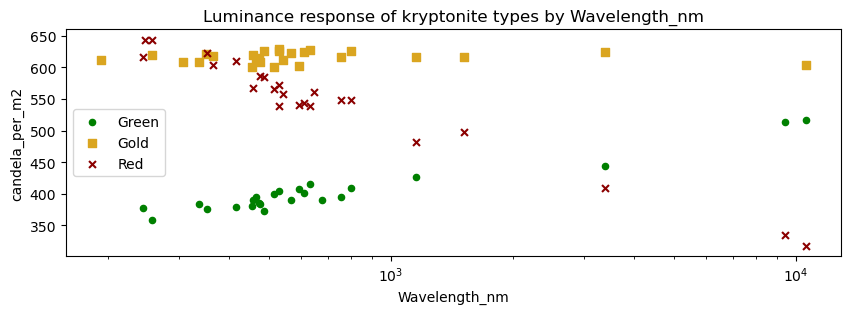

In [37]:
plot_kryptonite()

For this section, we are not necessarily interested in the full regression, but simply in imputing the *missing* observations.  In the table and the plot, you can see that some lasers in the test suite do not have available data against some types of kryptonite.  For example, the helium-neon laser at 1520㎚ was only tested against gold and red kryptonite.  And the CO₂ laser at 9400㎚ was only tested against the green and red kryptonite.

In [38]:
(krypt[
    (krypt.Wavelength_nm > 1500) & 
    (krypt.Wavelength_nm < 10000)]
 .sort_values('Wavelength_nm'))

Laser_type_kw Subtype  Wavelength_nm Kryptonite_type  candela_per_m2
5    Helium–neon     NaN         1520.0           Green             NaN
38   Helium–neon     NaN         1520.0             Red         497.592
71   Helium–neon     NaN         1520.0            Gold         616.262
6    Helium–neon     NaN         3391.3           Green         444.054
..           ...     ...            ...             ...             ...
72   Helium–neon     NaN         3391.3            Gold         624.755
28           CO2     NaN         9400.0           Green         514.181
61           CO2     NaN         9400.0             Red         334.444
94           CO2     NaN         9400.0            Gold             NaN

[9 rows x 5 columns]

While the two measures are directly computable from each other, electromagnetic frequencies in the visible range occupy a more linear numeric range, whereas wavelengths span several orders of magnitude.  For our purposes, it might be friendlier to work with laser frequencies.

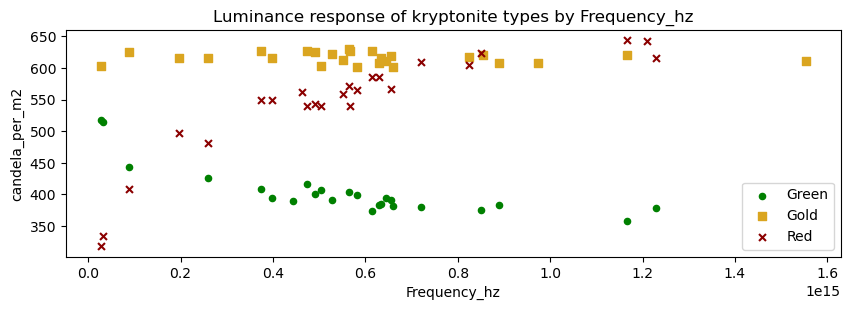

In [39]:
λ = krypt.Wavelength_nm / 10**9   # Wavelength in meters
c = 299_792_458                   # Speed of light in m/s
krypt['Frequency_hz'] = c/λ

# Plot frequency vs luminance
plot_kryptonite(df=krypt, logx=False,
                independent='Frequency_hz')

Visually, on a linear-linear plot using frequency, there clearly seems to be bend in the response curve for red kryptonite, and perhaps for the green as well.  Clearly the data is noisy, and does not closely match any smooth curve; whether this is because of the physical properties of the element or limitations in the experimental setup we do not know currently.  With this motivation, we might perform a polynomial fit of order higher than one.

In [40]:
# Only perform the polyfit on the non-missing data
kr_vals = (krypt[krypt.candela_per_m2.notnull()]
           .sort_values('Frequency_hz'))

# Do a fit for each kryptonite color
for color in ('Red', 'Green', 'Gold'):
    # Limit to the color being fit
    kcolor = kr_vals.loc[kr_vals.Kryptonite_type == color]
    x = kcolor["Frequency_hz"]
    y = kcolor["candela_per_m2"]
    coef2, coef1, offset = np.polyfit(x, y, deg=2)
    
    # Print out the discovered coefficients
    print(f"{color:>5s} (hz → nit): "
          f"{coef2:.1e}*x^2 + {coef1:.1e}*x + {offset:.1e}")

    # Use coefficients to fill missing values
    kmissing = krypt.loc[krypt.candela_per_m2.isnull() & 
                         (krypt.Kryptonite_type == color)]
    x = kmissing.Frequency_hz
    krypt.loc[x.index, 'candela_per_m2'] = (
                            coef2*x**2 + coef1*x + offset)

  Red (hz → nit): -2.6e-28*x^2 + 5.5e-13*x + 3.5e+02
Green (hz → nit): 1.4e-28*x^2 + -2.7e-13*x + 5.0e+02
 Gold (hz → nit): -4.1e-30*x^2 + 2.8e-15*x + 6.2e+02


Plotting again with the missing data imputed based on the polynomial fit, none of the new points appear obviously out of place.  Whether they are *correct* is, of course, something that requires much more domain knowledge.  At least our regression behaves as we expected it to.

In [41]:
plot_kryptonite(df=krypt, logx=False, imputed=True,
                independent='Frequency_hz')

By imputation, we have “filled in” all explicitly missing values, which makes many statistical tests and machine learning algorithms possible that are not without doing this.  Let us turn now to a more global issue of sampling.

## Sampling

**Concepts**:

* Categorical variables and discretized continuous variables
* Balancing target class values
* Sampling without replacement
* Sampling with replacement
* Oversampling by duplication
* Fuzzy statistical oversampling

Sampling is modification of a data set in order to rebalance it in some manner.  An imbalance can reflect *either* the data collection techniques used *or* the underlying pattern of the phenomenon you are measuring.  This imbalance can be particularly clear when a variable is categorical and there is an obvious explicit count of the class distribution.  A special kind of sampling is *time series resampling* which is discussed in chapter 7 (*Feature Engineering*).

An imbalance can also be relevant where the distribution of a continuous variable is merely uneven.  This is very common, since many quantities—in some sense, probably most quantities one can measure—are distributed unevenly, such as in a normal distribution or beta distribution.  For this purpose we exclude extremely "long tailed" distributions such as power law distributions or exponential distributions.  That is, a continuous value that simply has peaks within a comparatively narrow range presents a different issue than a value that spans many orders of magnitude.  Often it is useful to transform a long tailed distribution into a more linear one, for example by taking the log of the original values or discretizing the values into quantiles.

A simple example of a roughly normal distribution is human heights.  Drilling into the details, the actual data is probably somewhat bimodal based on sex, and may have additional second-order patterns by nationality, age, and so on.  For this simple illustration, the imbalance itself is sufficient for illustration.  Obviously humans vary in height, but even between the shortest newborn and the tallest adult, it is less than a 5x difference.  Among adults only (excluding some very rare, very short people), it is almost always within 1.5x.  In other words, height is essentially a linear quantity; but it is not one uniformly distributed.

The examples in this section will shift to using the R Tidyverse rather than Python.  Python data frame libraries—both Pandas and others—make everything shown equally easy; the switch is made under the assumption that more readers are more familiar with Python, as an effort to encourage readers to think about the concepts rather than the libraries narrowly.

In [42]:
%load_ext rpy2.ipython

We can read in a data set containing physical measurements of [25,000 (simulated) humans](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights#References).  For our purposes here, we just want to look at how height is distributed.

In [43]:
%%capture --no-stdout err
%%R -o humans
library('tidyverse')
humans <- read_csv('data/height-weight.csv')
humans


── Column specification ───────────────────────────────────────────────────────────────────
cols(
  Height = col_double(),
  Weight = col_double()
)

# A tibble: 25,000 x 2
   Height Weight
    <dbl>  <dbl>
 1   167.   51.3
 2   182.   61.9
 3   176.   69.4
 4   173.   64.6
 5   172.   65.5
 6   174.   55.9
 7   177.   64.2
 8   178.   61.9
 9   172.   51.0
10   170.   54.7
# … with 24,990 more rows


Dividing the heights into regular numeric increments we definitely see a vaguely Gaussian distribution, at least inasmuch as middling heights occur much more often than the shorter or taller ranges.  Even so, all humans in this sample—and almost all adults generally—are in the narrow range from 153㎝ to 191㎝.

In [60]:
humans.hist(figsize=(10,3), bins=12);
plt.savefig("img/(Ch06)humans-hist-Height_Weight.png")

In [45]:
%%R
table(cut(humans$Height, breaks = 5))


(153,161] (161,168] (168,176] (176,183] (183,191] 
      145      4251     14050      6229       325 


If height were the target we were trying to predict from other features (e.g. nutrition, nationality, gender, age, income, etc), for many kinds of machine learning models, the rare classes ("very short", "very tall") would nearly or absolutely never be predicted from other features.  There are simply too many people who are similar in those other measures to the small number (about 0.5% in the sample) of very short people that the default prediction would simply be "somewhat short" if not even just "average."

Note, however, that a similar problem exists if regions of the parameter space of the independent variables are imbalanced.  For example, if Indonesia or The Netherlands each had only a few samples in the hypothetical training set (but other nations many), we would be able to make little use of the fact that residents of those countries (as of this writing) had the shortest and tallest average heights, respectively.  Moreover, if the small number of samples included especially short Dutch people or especially tall Indonesian people, the presence of the class value might bias the prediction in exactly the opposite direction from what we would like.

### Undersampling

> The devil is in the details.<br/>–Einstürzende Neubauten

Let us look at a data set that uses actual categorical values rather than artificially discretized ranges.  The UCI Machine Learning 1997 [Car Evaluation Data Set](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) is useful here.  The original data set uses a variety of categorical words for ordinal values, such as the trunk being "small", "med", or "big", or the price of maintenance being "low", "med", "high", or "vhigh."  These are converted to sequential integer for this book.  However, the overall rating that we will focus on is left as descriptive words, even though it is also in an obvious implicit order.

In [46]:
%%capture --no-stdout err
%%R
cars <- read_csv('data/cars.csv', 
                 col_types = cols("i", "i", "i", "i", "i", "i", "f"))
cars

# A tibble: 1,728 x 7
   price_buy price_maintain doors passengers trunk safety rating      
       <int>          <int> <int>      <int> <int>  <int> <fct>       
 1         1              0     3          6     0      0 Unacceptable
 2         2              2     3          6     2      1 Acceptable  
 3         2              2     5          2     1      1 Unacceptable
 4         0              1     3          2     2      1 Unacceptable
 5         2              1     5          2     0      1 Unacceptable
 6         3              1     2          6     2      1 Acceptable  
 7         0              2     4          4     0      0 Unacceptable
 8         1              2     2          4     2      0 Unacceptable
 9         1              0     4          4     0      1 Acceptable  
10         1              3     3          2     0      0 Unacceptable
# … with 1,718 more rows


Imagine that we were trying to predict the "acceptability" of a car based on other recorded characteristics it has.  It stands out that in the first ten rows, a large number are unacceptable.  Let us look at the overal class distribution of the rating.

In [47]:
%%R
table(cars$rating)


Unacceptable   Acceptable    Very Good         Good 
        1210          384           65           69 


The evaluators of these cars are perhaps rather fussy in finding so very few of them good or very good.  In any case, this shows a strong imbalance in the rating feature, which we will perhaps use as the target in our classification model.  We would like to clean our training data in a manner likely to produce higher quality models.  Keep in mind that different specific modeling techniques are more, or less, likely to be impoved by sampling techniques than others.  For example, linear models are largely insensitive to class imbalance, while K-nearest neighbor models tend to be highly sensitive to these issues.  But even within a generalization of that sort, different sampling, of different data sets and domains, will be effective to varying degrees.  The choice of downstream model matters a lot.

If three things hold, undersampling is unproblematic:

* We have a great many rows in the data set;
* Even the uncommon classes have a reasonable number of samples;
* The parameter space is well covered by the samples.

If we are lucky enough to have all those conditions hold, simply selecting a sample size of the smallest class is adequate.  However, if we cannot reach those conditions—in particular, if the smallest classes are a bit too small—permitting a degree of imbalance is generally not terrible.  50:1 imbalance is likely to be a problem, 2:1 is likely to be unimportant.  For our car evaluation, let us attempt to find 100 samples from each class, but settle for as many as we have.  Having fewer than 100 samples of the uncommon classes in this data set does not give us very much leeway.

In [48]:
%%R
unacc <- sample(which(cars$rating == "Unacceptable"), 100)
acc <- sample(which(cars$rating == "Acceptable"), 100)
good <- sample(which(cars$rating == "Good"), 69)
vgood <- sample(which(cars$rating == "Very Good"), 65)
samples <- slice(cars, c(vgood, good, acc, unacc))
samples

# A tibble: 334 x 7
   price_buy price_maintain doors passengers trunk safety rating   
       <int>          <int> <int>      <int> <int>  <int> <fct>    
 1         0              0     5          6     2      2 Very Good
 2         1              1     3          6     2      2 Very Good
 3         0              1     5          6     1      2 Very Good
 4         0              1     5          6     2      2 Very Good
 5         0              1     4          4     1      2 Very Good
 6         0              1     5          4     1      2 Very Good
 7         0              1     3          6     2      2 Very Good
 8         1              0     5          6     2      2 Very Good
 9         0              0     5          4     1      2 Very Good
10         0              1     5          4     2      2 Very Good
# … with 324 more rows


Here we manually selected the number of rows available per class, and did not use higher level libraries like **DMwR** (Data Mining with R), **caret** (Classification And REgression Training), or **ROSE** (Random Over-Sampling Examples), which would make the sampling somewhat more concise.  These packages each include a variety of more sophisticated sampling techniques, some of which we will use shortly.  In the Python world, the package **imbalanced-learn** is the go-to choice, and includes most of the techniques in the mentioned R packages.<sup><i>packages</i></sup>

<div id="packages" 
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>packages</i><br/>
While there is much overlap between the tools available in R and Python, there are some differences in culture and focus between the languages and communities.  On the one hand, R is most certainly more focused on statistics, and the breadth of libraries available in that area run deeper; the libraries for other areas are shallower in R, correspondingly.<br/>

Beyond the technical focus though, there is a notable philosophical difference in the programming language communities.  Python tends to coalesce around common libraries with many contributors, or at least common APIs between libraries covering similar areas.  R tends to grow many packages, each with relatively fewer contributors, with only partial overlap in functionality and less insistence on shared APIs among packages.  NumPy, Pandas, scikit-learn, and much more narrowly imbalanced-learn, are "standard" APIs.  In contrast, in R, data.table, data.frame, and tibble compete with varying APIs and advantages; more narrowly, DMwR, caret, and ROSE likewise compete.
</div>    

Let use take a look at the distribution we obtained to make sure we did the intended thing.

In [49]:
%%R
samples %>%
  group_by(rating) %>%
  count()

# A tibble: 4 x 2
# Groups:   rating [4]
  rating           n
  <fct>        <int>
1 Unacceptable   100
2 Acceptable     100
3 Very Good       65
4 Good            69


Having only 60-some samples available at all from the uncommon classes is probably too sparse.  To a large extent, a class having few samples simply cannot cover the parameter space of the features, no matter what technique we use.  The 100 samples we have selected from the larger classes is not very much larger, but we can reasonably hope that since the underlying populations are much larger, and our sampling is unbiased, these samples are less likely to wholly miss parameter regions.

While sampling is imperfect, we can at least avoid a target imbalance which is likely to bias our model by combining undersampling with oversampling.  Let us take 150 samples from each class by allowing replacement (and hence duplication from low-count classes).

In [50]:
%%R
# Find indices for each class (dups OK)
indices <- unlist(
  lapply(
    # For each level of the rating factor,
    levels(cars$rating), 
    # sample with replacement 150 indices
    function(rating) {
      pred <- which(cars$rating == rating)
      sample(pred, 150, replace = TRUE) }))

# Check that we have drawn evenly
slice(cars, indices) %>%
  group_by(rating) %>%
  count()

# A tibble: 4 x 2
# Groups:   rating [4]
  rating           n
  <fct>        <int>
1 Unacceptable   150
2 Acceptable     150
3 Very Good      150
4 Good           150


### Oversampling

> God dwells in the details.<br/>–Ludwig Mies van der Rohe (c.f. Gustave Flaubert)

When data is plentiful, undersampling is a quick way of producing more balanced training data for machine learning models.  Most often data sets do not cover your parameter space so well that you can simply throw away training data with pure undersampling.  Even if you have quite a few observations, even the common classes will cluster around a prototypic region of the high dimensional space.  If you need to evaluate the parameter space as sensitively as possible, discarding data is risky.  Of course, it can also merely be the case that with the type of model and amount of computational resources you have, you simply cannot train a model on a full data set; if so, undersampling has an independent appeal, and class sensitivity in doing it is entirely a good thing.

We have already seen how to perform the simplest kind of oversampling.  In the car evaluation data set, for example, we could simply sample with replacement up to the count of the most common class.  Exactly that technique would create some noise in that most common class since some samples would be repeated and others omitted.<sup><i>sampling</i></sup> 

<div id="sampling"
     style="display: inline-block; margin: 0 5% 0 5%; border-style: solid; border-width: 1px">
    <i>sampling</i><br/>
The most straightforward approach to resampling per class does not differentiate the most common class from other classes.  This means that if the most common class has 100 items, resampling with replacement will omit approximately 36 of them in the resampled version, and duplicate other items.  In contrast, resampling to 100 items from a class that has only 10 initial items will with near certainty represent each item at least once.<br/><br/>

In concept, we could use extra code to do something somewhat more "fair".  We would create a copy of the original data. Then we would sample only `max_class_size-current_class_size` items from each other class. Then we would combine the untouched original with the new samples.  This at least would make sure that every original appears at least once in the resulting data.  While this approach might be an improvement, it remains less nuanced than approaches like SMOTE, discussed below.
</div>

Another approach is simply duplicating uncommon classes as many times as are needed to make them reach approximate parity with the more common ones.  For example:

In [51]:
# Read the raw data and count most common rating
cars = pd.read_csv('data/cars.csv')
cars2 = cars.copy()  # Modify a copy of DataFrame
most_common = max(cars2.rating.value_counts())

for rating in cars2.rating.unique():
    # A DataFrame of only one rating class
    rating_class = cars2[cars2.rating == rating]
    # Duplicate one less than overshooting most_common
    num_dups = (most_common // len(rating_class)) - 1
    for _ in range(num_dups):
        cars2 = pd.concat([cars2, rating_class])

cars2.rating.value_counts()

Unacceptable    1210
Good            1173
Very Good       1170
Acceptable      1152
Name: rating, dtype: int64

This approach brings each uncommon class as close to the frequency of the plurality class as is possible without being non-uniform in the duplication.  That is, if we wanted *exactly* 1210 "Acceptable" samples, we would duplicate some samples one more time than we had other samples.  Allowing a very slight imbalance is a better approach.

More interesting than naive oversampling is a technique called Synthetic Minority Over-sampling Technique (SMOTE), and a closely related one called Adaptive Synthetic Sampling Method for Imbalanced Data (ADASYN).  In R there are a number of choices for performing the SMOTE and similar techniques.  Libraries include smotefamily, DMwR, and ROSE for a related but slightly different technique.  For the next few code examples, however, we will use Python's imbalanced-learn instead, if only because there are fewer choices among the libraries needed.

While there are some technical differences among several techniques in the SMOTE family, they all are generally similar.  What they do is generate *new data points* using K-nearest neighbor techniques.  Among the minority samples, they look at the several nearest neighbors in the parameter space of features, and then create a new synthetic sample within that region of the parameter space which is not identical to *any* existing observation.  In an informal sense, we might call this "fuzzy" oversampling.  Of course, the class or target assigned to this synthetic point is the same as that of the cluster of minority class observations already existing.  The bottom line is that this kind of oversampling with fuzziness in feature values usually creates much more useful synthetic samples than does a crude oversampling.

As discussed above, the cars rating classes are starkly imbalanced.

In [52]:
cars.rating.value_counts()

Unacceptable    1210
Acceptable       384
Good              69
Very Good         65
Name: rating, dtype: int64

Several similar oversampling techniques are available in imbalanced-learn.  Read the documentation of the library for evolving details.  All of them are built on top of the same scikit-learn API, and they may be included within scikit-learn pipelines and otherwise interoperate with that library.  You do not need to use scikit-learn to use imbalanced_learn, except in the behind-the-scenes way that it utilizes K-nearest neighbors from that library.

Similar to the package name scikit-learn being imported under the module name `sklearn`, the installation package we use is named imbalanced-learn, but it is imported as `imblearn`.

In [53]:
# Only define the feature and target matrices, use in next cell
from imblearn.over_sampling import SMOTE

# Divide data frame into X features and y target
X = cars.drop('rating', axis=1)
y = cars['rating']

# Create the resamples features/target
X_res, y_res = SMOTE(k_neighbors=4).fit_resample(X, y)

Let us combine the features and target back into a DataFrame similar to the original.

In [54]:
synth_cars = X_res.copy()
synth_cars['rating'] = y_res
synth_cars.sample(8, random_state=2)

price_buy  price_maintain  doors  passengers  trunk  safety  \
748           2               2      5           6      0       0   
72            0               3      2           6      0       1   
2213          3               0      2           4      0       2   
1686          2               3      5           2      0       0   
3578          0               0      4           6      1       1   
3097          0               0      2           4      0       2   
4818          0               1      4           4      1       2   
434           2               3      5           6      2       0   

            rating  
748   Unacceptable  
72    Unacceptable  
2213    Acceptable  
1686  Unacceptable  
3578          Good  
3097          Good  
4818     Very Good  
434   Unacceptable

As we wish, the classes of the target are exactly balanced.  We could alter the sampling strategy not to require an exact balance, but in this case exactness is reasonable.

In [55]:
synth_cars.rating.value_counts()

Very Good       1210
Unacceptable    1210
Good            1210
Acceptable      1210
Name: rating, dtype: int64

A small point is worth noticing here.  Unlike the several R libraries that peform SMOTE, imbalanced-learn retains the data type of the features.  In particular, the ordinal integers of the features are kept as integers.  This may or may not be what you want.  Semantically, an evaluation of `price_buy` from "low" to "very high" could sensibly be encoded as a continuous value in the 0-3 range.  However, the number of doors is semantically an integer.  Still, if "more doors is better" for you as a consumer, there is likely no harm in a synthetic row with slightly nonsensible literal meaning.

More important than the direct interpretation of a given feature value is how useful the value is to your model.  For many kinds of models, continuous variables provide more useful clustering, and most likely you will prefer to train on floating-point inputs. Let us cast our data types to floats and perform the resampling again, taking note of some of the new non-integral feature values. 

In [56]:
cars.iloc[:, :6] = cars.iloc[:, :6].astype(float)
cars.head()

price_buy  price_maintain  doors  passengers  trunk  safety        rating
0        1.0             0.0    3.0         6.0    0.0     0.0  Unacceptable
1        2.0             2.0    3.0         6.0    2.0     1.0    Acceptable
2        2.0             2.0    5.0         2.0    1.0     1.0  Unacceptable
3        0.0             1.0    3.0         2.0    2.0     1.0  Unacceptable
4        2.0             1.0    5.0         2.0    0.0     1.0  Unacceptable

In [57]:
# Divide data frame into X features and y target
X = cars.drop('rating', axis=1)
y = cars['rating']

# Create the resamples features/target
X_, y_ = SMOTE().fit_resample(X, y)
pd.concat([X_, y_], axis=1).sample(6, random_state=4)

price_buy  price_maintain     doors  passengers   trunk  safety  \
4304        1.0        0.158397  2.158397         6.0  2.0000     2.0   
337         3.0        0.000000  3.000000         4.0  0.0000     1.0   
2360        2.0        2.000000  3.247795         4.0  2.0000     2.0   
3352        0.0        1.000000  2.123895         4.0  2.0000     1.0   
2064        0.0        3.000000  4.000000         6.0  1.8577     2.0   
4058        1.0        0.000000  3.075283         6.0  2.0000     2.0   

            rating  
4304     Very Good  
337   Unacceptable  
2360    Acceptable  
3352          Good  
2064    Acceptable  
4058     Very Good

## Exercises

For the exercises in this chapter, you will look first at evaluating the quality of imputed trends.  In the second exercise you will need to think about working with data that might be imbalanced in multiple features, not only in a single one.

### Alternate Trend Imputation

In the kryptonite example in this chapter, we used a second order polynomial fit on the input laser frequency to impute the missing values for candela per square meter.  In some sense it would definitely be simpler merely to use local interpolation, or even forward fill or backward fill.  Most data frame libraries give us those local imputations "out of the box."

The data set is available at:

> https://www.gnosis.cx/cleaning/excited-kryptonite.fwf

You should quantify the differences between different imputation approaches.  A good way to express the difference between samples is with root-mean-square deviation (RMSD), and for this exercise use that measure. Obviously, we do not know what the *correct* answer is for missing values, so we are only trying to evaluate how much different various approaches are from each other.

There are a number of differences you should measure and compare, for each color/type of kryptonite and for the aggregate of all colors:

* The RMSD between *all* points (original and imputed) and the 2nd order polynomial fit function itself.
* The RMSD between the *original* points and:
  * A linear regression on them;
  * A second order polynomial fit;
  * A third order polynomial fit;
  * Some other regression that you find relevant (perhaps from a machine learning library).
* The RMSD for only *imputed* points between polynomial fits of degrees 1, 2, and 3, and a local interpolation based on neighbors only.
* The RMSD for *imputed* points only between polynomial fits of varying degrees and a simple forward fill.

Describe what you feel is the best strategy to defeat that pesky Superman.  <span style="font-size:18pt">🦸</span>

### Balancing Multiple Features

The human height/weight data showed an imbalance in the numeric quantity `Height`.  `Weight` shows a simlar distribution.  A version of this data set with a fanciful target attached is available at:

> https://www.gnosis.cx/cleaning/height-weight-color.csv

This data adds a column called `Favorite` which is roughly equally balanced, and merely generated at random from the collecton {red, green, blue}.

In [58]:
humcol = pd.read_csv('data/height-weight-color.csv')
humcol.sample(6, random_state=1)

Height     Weight Favorite
21492  176.958650  72.604585      red
9488   169.000221  79.559843     blue
16933  171.104306  71.125528      red
12604  174.481084  79.496237     blue
8222   171.275578  77.094118    green
9110   164.631065  70.557834    green

For this exercise you wish to explore models to predict favorite color from height and weight.  We saw earlier in this chapter the distribution of heights.  Weight has a similar degree of imbalance between numeric ranges.

In [59]:
pd.cut(humcol.Weight, 5).value_counts().sort_index()

(44.692, 55.402]      125
(55.402, 66.06]      3708
(66.06, 76.717]     14074
(76.717, 87.375]     6700
(87.375, 98.033]      393
Name: Weight, dtype: int64

According to our stipulated hypothesis, height and weight might be predictive of favorite color.  However, we also hypothesize that body mass index (BMI) might be predictive.  This is deterministically derived from height and weight, but not according to the polynomial features derivation discussed in the chapter 6 (*Feature Engineering*).  Specifically, the BMI formula is:

$$BMI = \frac{kg}{m^2}$$

Your task is to create a new data set with synthetic samples, in which height alone, weight alone, and BMI are each represented by a relatively equal number of observations.  For this purpose, assume that height, weight, and BMI, each divide into *five* classes that you might informally call, e.g. 'very short', 'short', 'average', 'tall', 'very tall', or similar names for the other features.

A simple way to approach this problem is simply to duplicate existing rows in a manner to increase the representation of their quantized classes.  You might try that approach first.  However, you should also try to use a technique such as SMOTE, ADASYN, or ROSE that generate novel synthetic samples that are *representative* of their height, weight, or BMI classes.  As you generate these synthetic samples, you will need to assign an appropriate favorite color (this is straightforward when you merely duplicate rows; however, it will be more subtle as you create novel synthetic rows according to several different balancing requirements).

Given that the class imbalance is on the order of 100:1, but only among 5 classes per feature being balanced, each balancing operation, per feature, will increase the data set size by approximately 4x.  Think about whether those multiplications need to be chained, to produce a data set approximately 4×4×4, or 64 times the original size.  You should be able to arrive at a way of balancing independently by feature, thereby limiting the expansion to approximately 4+4+4, or 12 times the original size.

Oversampling up to, say, 300,000 rows is not unduly unwieldy.  However, if you had started with more than 25,000 observations, the multiplication might be so.  Assuming your initial oversampling indeed produces something on the order of 300,000 rows of data, undersample those 300k mostly synthetic samples down to only 100,000 in a manner that maintains rough class balance (precise balance is not required here; aim for less than 25% difference in row count per class).

As a final element of this exercise, if you are able to get to it, try to create an actual model of the relationship between height, weight, BMI, and the target favorite color.  Specific modeling or machine learning techniques are outside the scope of this book, but they often are the purpose for which this book hopes to be helpful.

* How good of a prediction does your model make? 
* *What* predction does you model make? Which people prefer which color, and how strongly?
* Which feature is most strongly predictive?

As a hint, I will indicate that a relatively strong pattern is embedded in the favorite color assignment.  There is a lot of noise and randomness in there as well, as you would expect if we had actual survey data about favorite color.  But there are also patterns that most likely do not actually exist between physical measurements and this preference.

## Denouement

> Never answer the question that is asked of you. Answer the question 
> that you wish had been asked of you.<br/>–Robert McNamara

**Topics**: Central Tendency; Correlated Tendencies; Trend Imputation; Locality; Undersampling; Oversampling

In this chapter we looked at two related, but slightly different, main concepts.  On the one hand, it is often useful to impute individual values where data is missing.  When we do this, we can use a variety of patterns in the data and/or facts we know about the underlying domain that the data is drawn from.  Sometimes we impute values based on what is typical for a given variable, sometimes conditioning typicality on a particular region of parameter space.  Other times we find trends in data that can be sequenced in some manner, and impute based on those trends.

Under the second aspect, a kind of imputation occurs with sampling as well.  In the case of oversampling, we straightforwardly impute entirely new synthetic samples, either simply by repeating existing ones or using aggregation techniques to extrapolate what is typical of an uncommon class.  However, even in the case of undersampling, there is a kind of imputation going on.  Undersampling a data set does not change any individual values, but it absolutely changes the *distribution* of the remaining data.  That is, after, all the whole point: we wish to create relative balance within a categorical or range variable that the original data set does not follow.

For data science and data analysis, your burden is always to take the crude material that is presented to you in raw form, and give it a form suitable for modeling and analytic purposes.  In the next chapter we move on to looking at *feature engineering* and creation of novel synthetic features.